In [1]:
!pip install chronos-forecasting

In [32]:
# ======================================================
# Ridge
# ======================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================================================
# 1. Load raw price data and parse into structured format
# ======================================================

DATA_PATH = "/Users/sabrinawang/Downloads/AI驱动的预测方法/Project/SnP_daily_update.csv"

raw = pd.read_csv(DATA_PATH, header=None, low_memory=False)

tickers = raw.iloc[1, 1:].values

data = raw.iloc[3:].copy()
data = data.rename(columns={0: "Date"})
data["Date"] = pd.to_datetime(data["Date"])

data.columns = ["Date"] + list(tickers)

# ======================================================
# 2. Convert wide-format price table into long-format panel data
# Each row represents (Date, Stock, Close Price)
# ======================================================

df = data.melt(
    id_vars="Date",
    var_name="Symbol",
    value_name="Close"
)

df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna().sort_values(["Symbol", "Date"]).reset_index(drop=True)

# ======================================================
# 3. Keep only the most recent 250 observations per stock
# This ensures comparable history length and avoids extremely old data
# ======================================================

df = (
    df.groupby("Symbol", group_keys=False)
      .tail(250)
      .reset_index(drop=True)
)


# ======================================================
# 4. Compute daily log returns as prediction target
# Log returns stabilize variance and remove price scale effects
# ======================================================

df["log_return"] = (
    df.groupby("Symbol")["Close"]
      .transform(lambda x: np.log(x / x.shift(1)))
)

df = df.dropna().reset_index(drop=True)

df["log_return"] = df["log_return"].clip(lower=-0.2, upper=0.2)


# ======================================================
# 5. Feature engineering: lagged returns and rolling statistics
# These features capture short-term memory and volatility patterns
# ======================================================

LAGS = [1, 2, 3, 5, 10]
ROLLS = [5, 10, 20]

for lag in LAGS:
    df[f"lag_{lag}"] = df.groupby("Symbol")["log_return"].shift(lag)

for w in ROLLS:
    df[f"roll_mean_{w}"] = (
        df.groupby("Symbol")["log_return"]
          .rolling(w)
          .mean()
          .reset_index(level=0, drop=True)
    )
    df[f"roll_std_{w}"] = (
        df.groupby("Symbol")["log_return"]
          .rolling(w)
          .std()
          .reset_index(level=0, drop=True)
    )

df = df.dropna().reset_index(drop=True)

# ======================================================
# 6. Prediction target: next-day log return
# ======================================================

df["target"] = df.groupby("Symbol")["log_return"].shift(-1)
df = df.dropna().reset_index(drop=True)

# ======================================================
# 8. Feature matrix
# ======================================================

FEATURES = [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df[FEATURES]
y = df["target"]
dates = df["Date"]

# ======================================================
# 8. Time-based train-test split to avoid look-ahead bias
# ======================================================

H = 50 

df = df.sort_values(["Symbol", "Date"]).reset_index(drop=True)

df["rank_in_symbol"] = (
    df.groupby("Symbol")["Date"]
      .rank(method="first", ascending=True)
)

df["n_in_symbol"] = df.groupby("Symbol")["Date"].transform("count")

df["is_test"] = df["rank_in_symbol"] > (df["n_in_symbol"] - H)

X = df[FEATURES]
y = df["target"]

X_train = X[~df["is_test"]]
y_train = y[~df["is_test"]]

X_test = X[df["is_test"]]
y_test = y[df["is_test"]]


# ======================================================
# 9. Ridge regression baseline
# ======================================================

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

results = pd.DataFrame({
    "Model": ["Ridge"],
    "MAE": [ridge_mae],
    "RMSE": [ridge_rmse]
})

print(results)

# ======================================================
# 10. Sanity check
# ======================================================

df[["Date", "Symbol", "log_return"]].head()
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Unique symbols in train:", df.loc[~df["is_test"], "Symbol"].nunique())
print("Unique symbols in test:", df.loc[df["is_test"], "Symbol"].nunique())


   Model       MAE      RMSE
0  Ridge  0.009996  0.015016
Train size: (89614, 11)
Test size: (25050, 11)
Unique symbols in train: 501
Unique symbols in test: 501


In [6]:
# ======================================================
# Chronos forecasting: zero-shot time series prediction
# ======================================================

from chronos import ChronosPipeline
import torch

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu"
)


In [27]:
# ======================================================
# 1. Construct historical input: last LOOKBACK days before prediction time
# ======================================================

symbol = df["Symbol"].iloc[0]
LOOKBACK = 30

sym_df = df[df["Symbol"] == symbol].sort_values("Date").reset_index(drop=True)

hist = torch.tensor(sym_df["log_return"].values[-LOOKBACK:], dtype=torch.float32)
forecast = pipeline.predict(hist, prediction_length=1)

print("Raw forecast tensor:", forecast)
print("Mean prediction:", forecast.mean().item())



Raw forecast tensor: tensor([[[ 1.2157e-09],
         [-6.3799e-04],
         [ 3.8279e-03],
         [-1.2760e-03],
         [ 3.8279e-03],
         [-1.4674e-02],
         [-6.3799e-04],
         [ 4.4659e-03],
         [ 7.6558e-03],
         [ 5.7419e-03],
         [ 8.9318e-03],
         [-6.3799e-04],
         [ 1.2760e-03],
         [-2.2202e-01],
         [ 3.1899e-03],
         [-1.4036e-02],
         [-6.3799e-04],
         [-1.1484e-02],
         [ 1.9905e-01],
         [ 1.2157e-09]]])
Mean prediction: -0.0014035642379894853


In [30]:
# ======================================================
# 2. Generate 20 stochastic forecasts and take their mean as final prediction
# ======================================================

H = 50
LOOKBACK = 30

symbols = df.loc[df["is_test"], "Symbol"].unique()[:20]  

chronos_preds = []

for sym in symbols:
    sym_df = df[df["Symbol"] == sym].sort_values("Date").reset_index(drop=True)
    test_idx = sym_df.index[sym_df["is_test"]].tolist()

    for idx in test_idx:
        start = idx - LOOKBACK
        if start < 0:
            chronos_preds.append((sym, sym_df.loc[idx, "Date"], float("nan")))
            continue

        hist = torch.tensor(
            sym_df.loc[start:idx-1, "log_return"].values,
            dtype=torch.float32
        )

        forecast = pipeline.predict(hist, prediction_length=1)
        pred = forecast.mean().item()  
        # Store prediction for later evaluation
        chronos_preds.append((sym, sym_df.loc[idx, "Date"], pred))


In [31]:
# ======================================================
# 3. Evaluate prediction accuracy on the test set
# ======================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

chronos_pred_df = pd.DataFrame(
    chronos_preds, columns=["Symbol", "Date", "chronos_pred"]
)

eval_df = df[df["is_test"]].merge(
    chronos_pred_df, on=["Symbol", "Date"], how="inner"
)

chronos_mae = mean_absolute_error(eval_df["target"], eval_df["chronos_pred"])
chronos_rmse = np.sqrt(mean_squared_error(eval_df["target"], eval_df["chronos_pred"]))

print(f"Chronos MAE: {chronos_mae:.6f}")
print(f"Chronos RMSE: {chronos_rmse:.6f}")


Chronos MAE: 0.101196
Chronos RMSE: 0.138047


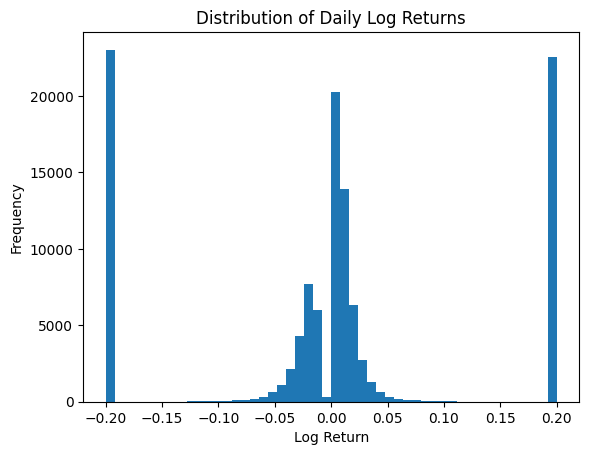

In [34]:
# ======================================================
# Visualization of comparisons
# ======================================================
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["log_return"], bins=50)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()


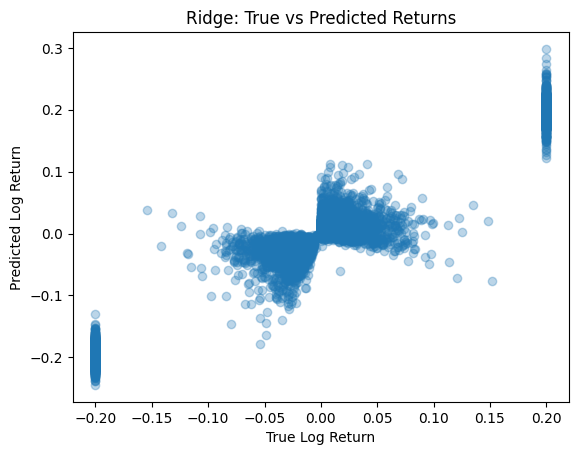

In [35]:
plt.figure()
plt.scatter(y_test, ridge_pred, alpha=0.3)
plt.xlabel("True Log Return")
plt.ylabel("Predicted Log Return")
plt.title("Ridge: True vs Predicted Returns")
plt.show()


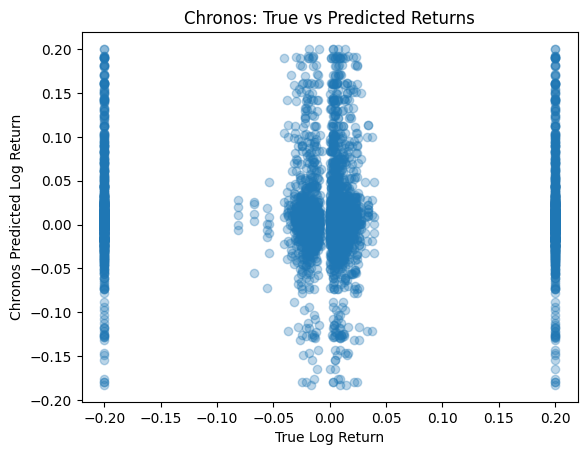

In [36]:
plt.figure()
plt.scatter(eval_df["target"], eval_df["chronos_pred"], alpha=0.3)
plt.xlabel("True Log Return")
plt.ylabel("Chronos Predicted Log Return")
plt.title("Chronos: True vs Predicted Returns")
plt.show()


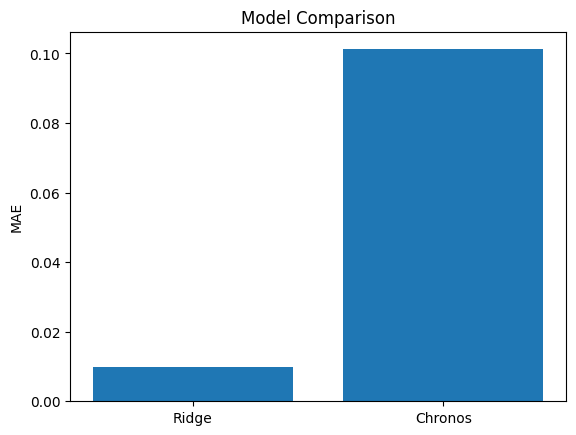

In [41]:
models = ["Ridge", "Chronos"]
maes = [ridge_mae, chronos_mae]


plt.figure()
plt.bar(models, maes)
plt.ylabel("MAE")
plt.title("Model Comparison")
plt.show()


In [ ]:
# ======================================================
# Trying to predict with LLM
# ======================================================
# import dashscope
# from dashscope import Generation
# import os

# # 1. Set API Key
# dashscope.api_key = "sk-ddd6a04d9d9c4137a8a5d201d5992e85"

# # 2. Build time series
# series = (
#     df[df["Symbol"] == "AAPL"]["log_return"]
#     .tail(30)
#     .round(4)
#     .tolist()
# )

# prompt = f"""
# You are a time series forecasting assistant.

# The following numbers are daily log returns of a stock:
# {series}

# Please predict the next day's log return (a real number).
# Briefly explain your reasoning.
# """

# # 3. Call Qwen
# response = Generation.call(
#     model="qwen-max",   # 或 qwen-plus / qwen-turbo
#     prompt=prompt
# )

# print(response)


#Output：{"status_code": 200, "request_id": "b900b31a-c0ba-489a-8081-810f0210b27f", 
#"code": "", "message": "", "output": {"text": "To predict the next day's log return, 
#we can look for patterns or trends in the given data. The series of daily log returns 
#appears to have a repeating pattern, particularly with the values 0.2 and -0.2 
#appearing frequently and in a somewhat regular manner.
#Let's break down the sequence: 
#1. Identify the Pattern: The sequence starts with 0.2, followed by -0.2, and then 
#some smaller values. This pattern (0.2, -0.2) repeats  multiple times throughout the 
#series.
#After each pair of 0.2 and -0.2, there are a few small values that vary, but they do
#not seem to follow a strict pattern.
#2. Analyze the Last Few Values:  
#- The last few values in the sequence are: 0.2, -0.2, 0.0005, -0.0108, 0.0047.
#The last complete pair is 0.2, -0.2, which fits the observed pattern.
#3. Predict the Next Value:
#Given the pattern, after the 0.2, -0.2 pair, the next value is typically a small 
#positive or negative number.
#The small values following the 0.2, -0.2 pairs are: 0.0032, -0.0136, 0.0038, 0.0158,
#-0.0165, 0.0123, 0.0053, -0.0247, 0.0246, 0.0034, -0.0173, 0.0083, 0.0107, -0.0124, 
#0.0086, 0.0005, -0.0108, 0.0047.
#These small values are relatively close to zero, and they alternate between positive
#and negative.
#Given the observed pattern, the next value is likely to be a small number, possibly 
#positive, as the previous small values after a -0.2 were 0.0005 and 0.0047, both positive.
#Prediction：
#The next day's log return is predicted to be a small positive number. A reasonable 
#estimate could be around 0.005 (or another small positive value close to zero).
#Reasoning:
#The pattern of 0.2, -0.2, followed by small values, suggests that the next value 
#will be a small positive number, consistent with the recent trend of small positive 
#values following -0.2.
#Thus, the predicted next day's log return is approximately **0.005**.", 
#"finish_reason": "stop", "choices": null}, "usage": 
#{"input_tokens": 250, "output_tokens": 616, "prompt_tokens_details": 
#{"cached_tokens": 0}, "total_tokens": 866}}